In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import hashlib

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230620',
              'user':'student', 
              'password':'dpo_python_2020'
             }

query = '''
select exp_group,
       user_id, 
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes,
       likes / views as ctr
from {db}.feed_actions 
where toDate(time) between toDate('2023-05-31') and toDate('2023-06-06')
and exp_group in (0, 1, 2, 3)
group by exp_group, user_id 
'''

df = ph.read_clickhouse(query, connection=connection)

Считаем метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 по группам 0 и 3

In [4]:
ctr_control = df.query('exp_group == 3').likes.sum() / df.query('exp_group == 3').views.sum()
df['lin_likes'] = df.query('exp_group in (0, 3)').likes - ctr_control * df.query('exp_group in (0, 3)').views

Построим гистограммы распределения рассчитанной метрики и первоначальных значений CTR по обеим группам

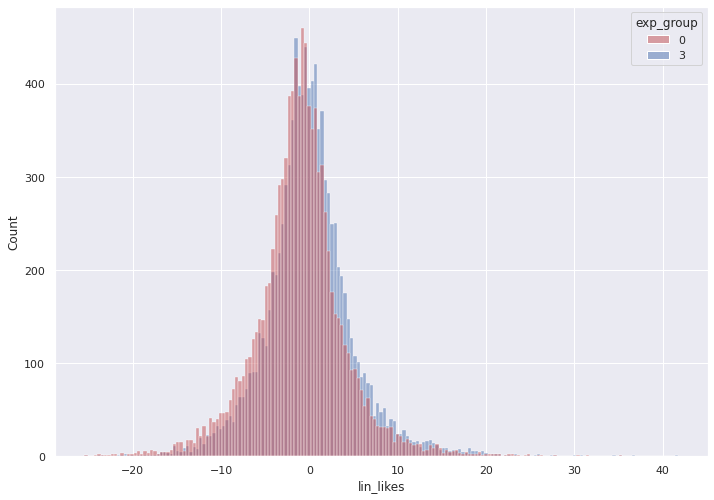

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df.query('exp_group in (0, 3)'), 
              x='lin_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

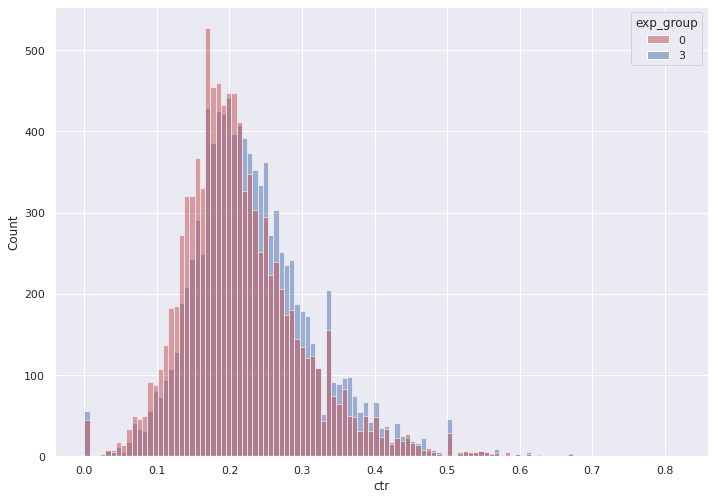

In [7]:
groups = sns.histplot(data = df.query('exp_group in (0, 3)'), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Как видно на производной метрике получили распределение менее зашумленное и сглаженное, также оно отцентрировалось вокруг нуля.

Рассчитаем t тесты по обоим вариантам

In [17]:
stats.ttest_ind(df.query('exp_group == 0').ctr, 
                df.query('exp_group == 3').ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [18]:
stats.ttest_ind(df.query('exp_group == 0').lin_likes, 
                df.query('exp_group == 3').lin_likes,
                equal_var=False)

Ttest_indResult(statistic=-14.944877938074978, pvalue=3.138452055341442e-50)

Как видим, t тест на производной метрике выдал значение pvalue существенно ниже, чем при расчетах на обычной метрике CTR, таким образом, использование в тесте показателя 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 сделал его более чувствительным

Аналогично посчитаем метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 по группам 1 и 2, построим гистограммы и расчитаем тесты

In [20]:
ctr_control = df.query('exp_group == 2').likes.sum() / df.query('exp_group == 2').views.sum()
df['lin_likes'] = df.query('exp_group in (1, 2)').likes - ctr_control * df.query('exp_group in (1, 2)').views

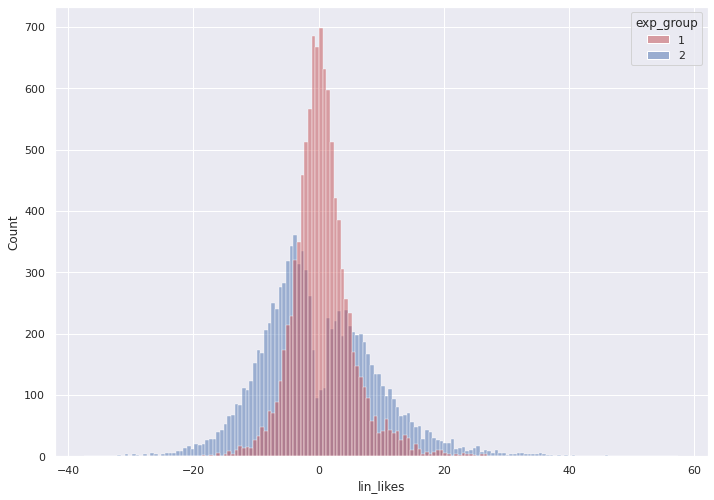

In [21]:
groups = sns.histplot(data = df.query('exp_group in (1, 2)'), 
              x='lin_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

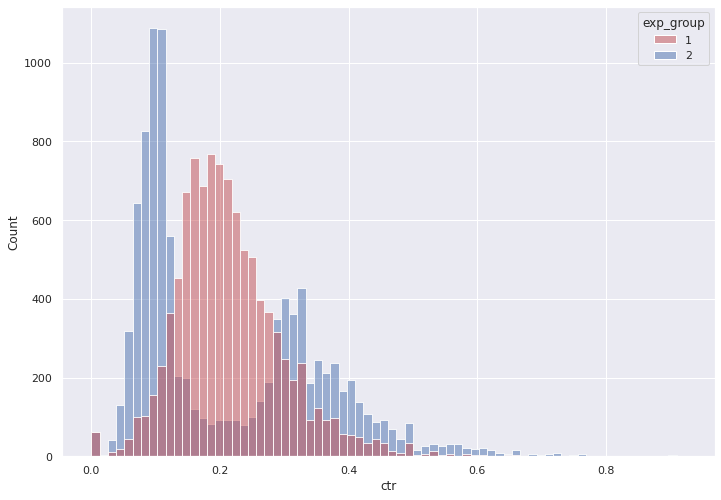

In [22]:
groups = sns.histplot(data = df.query('exp_group in (1, 2)'), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [23]:
stats.ttest_ind(df.query('exp_group == 1').ctr, 
                df.query('exp_group == 2').ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [24]:
stats.ttest_ind(df.query('exp_group == 1').lin_likes, 
                df.query('exp_group == 2').lin_likes,
                equal_var=False)

Ttest_indResult(statistic=6.197325335831903, pvalue=5.895241523584303e-10)

Аналогично использование в тесте производной метрики увеличило его чувствительность (значение pvalue оказалось существенно ниже) - и если при использовании простой метрики CTR t тест сработал ошибочно и не увидел значимых различий (см. выводы к заданию 5.2), то уже на расчетной метрике тест корректно показал значимые различия с экстремально низким значением pvalue